####                                                                                                                                                                                            Carol Chiu 
####                                                                                                                                                                                            April 16, 2020


# Wind Speed Time Series Forecasting Report

### Objective: 
######The goal of this project is to accurately and efficiently forecast wind speeds occurring at a powerplant operation in Marmara, Turkey. Marmara is a region of Turkey that is known for her high wind speeds with the average wind speed reaching as fast as 3.3 m/s. As a powerplant operator, I am interested in protecting my special equipment that can only function properly when wind speeds are below 50 mph. I have a protection system installed for my equipment but it takes 5 minutes for the system to fully load and work. Thus, I need an accurate predictive model that I can use to sound an alarm when the wind speed might be greater than 50 mph in the next 5 minutes of the operation. Doing so will save me in damage costs to my powerplant and reduce health hazard and safety hazard costs to my employees, clients, and myself.

### Source of Data: 
######Wind speed data is obtain from ASOS censors developed by the 

### Methods Used:
######1) ARIMA Model
######2) VARMAX Model
######3) SARIMAX Model
######4) Hidden Markov Model
######5) Triple Exponential Smoothing Model

### Exploratory Data Analysis for One Month (December 2001) :

In [30]:
#Import Packages and Read in CSV
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

data12 = pd.read_csv("./2001-12.csv")

In [31]:
#View DataFrame for the month of December 2001
data12

,Unnamed: 0,call_sign,ID,coef,d/n,max_speed,max_dir,avg_speed,avg_dir,month
0,107,14737KABE,ABE2001120101480648,0.146,N,211.0,7.0,198.0,8.0,12
1,243,14737KABE,ABE2001120104040904,0.481,N,202.0,3.0,198.0,3.0,12
2,244,14737KABE,ABE2001120104050905,0.478,N,199.0,3.0,197.0,3.0,12
3,245,14737KABE,ABE2001120104060906,0.630,N,197.0,3.0,196.0,3.0,12
4,246,14737KABE,ABE2001120104070907,0.983,N,197.0,3.0,197.0,3.0,12
...,...,...,...,...,...,...,...,...,...,...
2263,34740,14737KABE,ABE2001122903120812,0.071,N,201.0,1.0,196.0,1.0,12
2264,34742,14737KABE,ABE2001122903140814,0.076,N,199.0,2.0,198.0,2.0,12
2265,34743,14737KABE,ABE2001122903150815,0.076,N,197.0,2.0,196.0,2.0,12
2266,34794,14737KABE,ABE2001122904060906,0.084,N,211.0,3.0,199.0,3.0,12


In [32]:
#Fill in Missing Values with Linear Regression Imputation
def regression_imputation(df, impute_column, X_columns, missingness_column, regression = 'linear'):
    
    if regression == 'linear':
        model = LinearRegression()
    elif regression == 'logistic':
        model = LogisticRegression()
    
    model.fit(df[X_columns], df[impute_column])
    
    regression_impute = [df.loc[i,'avg_speed'] if df.loc[i,'avg_speed'] == 0
                         else model.predict(pd.DataFrame(df.loc[i,['coef', 'max_speed', 'max_dir',"avg_dir","month"]]).T)[0] 
                         for i in range(df.shape[0])]
    
    return regression_impute

In [33]:
data12['avg_speed_regression_imputed'] = regression_imputation(data12,'avg_speed', ['coef', 'max_speed', 'max_dir',"avg_dir","month"],'avg_speed')

In [34]:
#We want to convert our datatypes from Objects to Floats/Integers.
data12['avg_speed'] = pd.to_numeric(data12['avg_speed'])
data12['month'] = pd.to_numeric(data12['month'],errors='coerce')
data12['coef'] = pd.to_numeric(data12['coef'],errors='coerce')
data12['max_speed'] = pd.to_numeric(data12['max_speed'],errors='coerce')
data12['max_dir'] = pd.to_numeric(data12['max_dir'],errors='coerce')
data12['avg_dir'] = pd.to_numeric(data12['avg_dir'],errors='coerce')
data12['avg_speed_regression_imputed'] = pd.to_numeric(data12['avg_speed_regression_imputed'],errors='coerce')

In [35]:
#We only want certain columns that contain our values of interest in the final Dataframe.
data12 = data12[["coef","max_speed","max_dir","avg_speed","avg_dir","month","avg_speed_regression_imputed"]]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


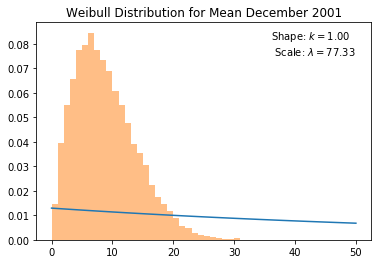

In [36]:
#Since the ARIMA model assumed our mean if normally distributed, we want to see if our mean is normally distributed.
from scipy import stats
import matplotlib.pyplot as plt

#input for pseudo data
N = 10000
Kappa_in = 1.8
Lambda_in = 10
a_in = 1
loc_in = 0 

#Generate data from given input
data = stats.exponweib.rvs(a=a_in,c=Kappa_in, loc=loc_in, scale=Lambda_in, size = N)

#The a and loc are fixed in the fit since it is standard to assume they are known
a_out, Kappa_out, loc_out, Lambda_out = stats.exponweib.fit(data12, f0=a_in,floc=loc_in)

#Plot
bins = range(51)
fig = plt.figure() 
ax = fig.add_subplot(1, 1, 1)
plt.title("Weibull Distribution for Mean December 2001")
ax.plot(bins, stats.exponweib.pdf(bins, a=a_out,c=Kappa_out,loc=loc_out,scale = Lambda_out))
ax.hist(data, bins = bins , normed=True, alpha=0.5)
ax.annotate("Shape: $k = %.2f$ \n Scale: $\lambda = %.2f$"%(Kappa_out,Lambda_out), xy=(0.7, 0.85), xycoords=ax.transAxes)
plt.show()

#####Our mean is not normally distributed and is skewed to the right. See reference(3) below for article on how to use the Weibull distribution to transform our data to become normal so that the ARIMA assumption of normality is satisfied.

In [37]:
#Since our means are not normally distributed, we want to apply a Weibull distribution transformation to make our data Gaussian/ normal.

data12["avg_speed_imputed_transform"] = np.sqrt(np.sqrt(data12["avg_speed_regression_imputed"]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
mask1 = data12['avg_speed_imputed_transform']>0

In [39]:
data12= data12[mask1]

In [40]:
#View the completed DataFrame for December 2001
data12.head()

,coef,max_speed,max_dir,avg_speed,avg_dir,month,avg_speed_regression_imputed,avg_speed_imputed_transform
0,0.146,211.0,7.0,198.0,8.0,12,200.108448,3.761113
1,0.481,202.0,3.0,198.0,3.0,12,188.698452,3.706313
2,0.478,199.0,3.0,197.0,3.0,12,186.432626,3.695136
3,0.630,197.0,3.0,196.0,3.0,12,184.985096,3.687943
4,0.983,197.0,3.0,197.0,3.0,12,185.129551,3.688663


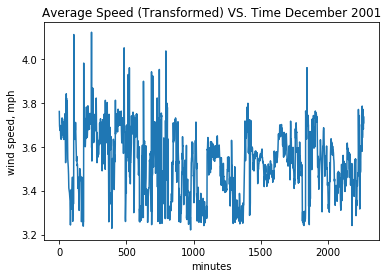

In [41]:
#View plot of Average Speed(Transformed) versus Time
plt.plot(data12['avg_speed_imputed_transform'].index, data12['avg_speed_imputed_transform'])
plt.title("Average Speed (Transformed) VS. Time December 2001");
plt.xlabel("minutes");
plt.ylabel("wind speed, mph");

### Introduction to ARIMA Modeling on December 2001:
######1) ARIMA (Autoregressive Integrated Moving Average) model is a time series forecasting technique that predicts the future values of its own data based on its past history. The model appreciates data that has a consistent pattern over time (1). It has three parameters that define it: p, d, and q. The first parameter, d, is the "differencing" parameter which we use to make our time series stationary. The second parameter, p, is the "autoregressive" peice which is responsible for modeling the long-term trends in our data but does not handle sudden, random changes or "shocks." The last parameter, q, is the "moving average" peice which does handle sudden, random shocks in our model by using previous error inputs to our model to predict the next value based on deviations from previous predictions. The ARIMA model is a mixture of the "autoregressive" or AR component and the "moving average" or MA component where it predicts future values based on past data but can also account for "new information" or sudden shocks to the model (2).

In [42]:
#Create the ARIMA Model
# Apply the first and second differencing (d =1 and d = 2) to 
data12['first_diff'] = data12['avg_speed_imputed_transform'].diff(1)
data12['second_diff'] = data12['avg_speed_imputed_transform'].diff(1).diff(1)

In [43]:
#Use the Augmented Dickey-Fuller test to determine the value of d
from statsmodels.tsa.stattools import adfuller
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [44]:
interpret_dftest(adfuller(data12['avg_speed_imputed_transform']))

Test Statistic   -6.745710e+00
p-value           3.038926e-09
dtype: float64

In [45]:
interpret_dftest(adfuller(data12['first_diff'].dropna()))

Test Statistic   -1.385164e+01
p-value           6.987390e-26
dtype: float64

In [46]:
interpret_dftest(adfuller(data12['second_diff'].dropna()))

Test Statistic   -1.738517e+01
p-value           5.046345e-30
dtype: float64

#####Since the p-value for the target value is less than 5% without differencing, we can reject the null hypothesis that our data is not stationary and select d = 0.

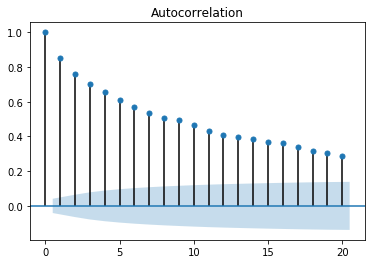

In [47]:
# Generate ACF and PACF plot to determine the value of p.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data12['avg_speed_imputed_transform'], lags = 20);

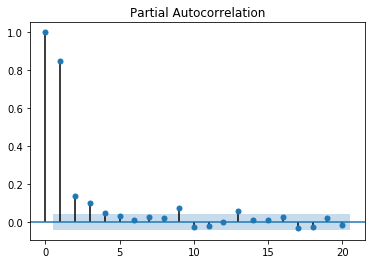

In [48]:
plot_pacf(data12['avg_speed_imputed_transform'], lags = 20);

In [49]:
#Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data12[['coef', 'max_speed', 'max_dir',"avg_dir","month"]],
                                                    data12['avg_speed_imputed_transform'],
                                                    test_size = 0.2,shuffle = False)

In [50]:
#Create the ARIMA model.
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(endog = y_train.astype(float).dropna(), 
              order = (0,0,1))

In [51]:
arima_0_1_0 = model.fit()

In [52]:
# Generate predictions.
start_index =X_train.index.min()+1
end_index = X_test.index.max()

preds = model.predict(params= arima_0_1_0.params, start=start_index, end=end_index)

In [53]:
data12['ARIMA_pred'] = pd.DataFrame(preds)

In [54]:
data12.head()

,coef,max_speed,max_dir,avg_speed,avg_dir,month,avg_speed_regression_imputed,avg_speed_imputed_transform,first_diff,second_diff,ARIMA_pred
0,0.146,211.0,7.0,198.0,8.0,12,200.108448,3.761113,NaN,NaN,3.633953
1,0.481,202.0,3.0,198.0,3.0,12,188.698452,3.706313,-0.054800,NaN,3.567978
2,0.478,199.0,3.0,197.0,3.0,12,186.432626,3.695136,-0.011176,0.043623,3.605626
3,0.630,197.0,3.0,196.0,3.0,12,184.985096,3.687943,-0.007194,0.003983,3.578984
4,0.983,197.0,3.0,197.0,3.0,12,185.129551,3.688663,0.000720,0.007913,3.597500


In [55]:
#Keep only positive values
neg = data12[data12.ARIMA_pred < 0]
data12 = data12.drop(neg.index)

In [56]:
#Fill NAs with zeros
data12 = data12.fillna(0)

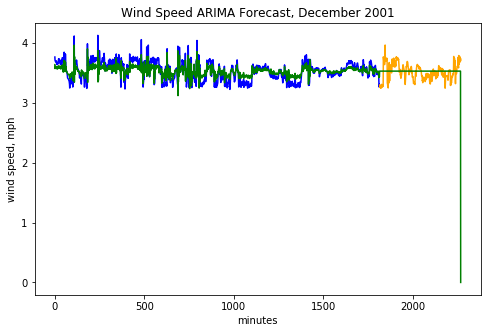

In [57]:
# Plot data.
plt.figure(figsize=(8,5))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')
# Plot predicted test values.
plt.plot(data12['ARIMA_pred'].index, data12['ARIMA_pred'] , color = 'green')
# Set label.
plt.title(label = 'Wind Speed ARIMA Forecast, December 2001');
plt.xlabel("minutes");
plt.ylabel("wind speed, mph");


#####Results: The ARIMA model has a low MSE and MSE and is good at predicting the average wind speeds for the powerplant. This may be due to the fact that we transformed the data into a stationary pattern, making it easier for the ARIMA to discern a pattern based on past history and predict consistently for the future wind speeds.

In [58]:
from sklearn.metrics import mean_squared_error
import statistics
import math
mse = mean_squared_error(data12['avg_speed_imputed_transform'],data12['ARIMA_pred'])
print("ARIMA MSE is:", mse)
rmse = math.sqrt(mse)
print("ARIMA RMSE is:", rmse)
mean1 = statistics.mean(data12['avg_speed_imputed_transform'])
print("Avg Wind Speed is:", mean1 )
mean2 = statistics.mean(data12['ARIMA_pred'])
print("Avg Wind Speed Prediction is:", mean2 )

ARIMA MSE is: 0.015549383441389068
ARIMA RMSE is: 0.12469716693409304
Avg Wind Speed is: 3.523245200444747
Avg Wind Speed Prediction is: 3.5242311070008188


### Introduction to Exponential Smoothing for Time Series Forecasting on all 12 months in 2001:

####Exponential smoothing forecasting is one of the best methods for time series forecasting in univariate data that can be used to include systematic trends and/or seasonal components. Time series methods such as the ARIMA model form predictions as a weighted linear sum of recent past observations or lags. Exponential smoothing forecasting is similar in that it also forms a weighted sum of past observations but it uses an exponentially decreasing weight for past observations. There are three forms to exponential smoothing but we will be using the most advanced form here which is the triple exponential smoothing method that accounts for systematic behavior including trends and seasonality (4)!

In [59]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

data = pd.read_csv("./1-12_final.csv")

In [60]:
data

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1,...,coef,d/n,max_speed,max_dir,avg_speed,avg_dir,month,VARMAX_pred,avg_speed_regression_imputed,avg_speed_imputed_transform
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.950,N,43.0,2.0,40.0,2.0,1,3.941545,41.042636,2.531097
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.974,N,40.0,2.0,41.0,2.0,1,3.084103,39.349417,2.504578
2,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.728,N,36.0,2.0,23.0,2.0,1,2.356797,37.250066,2.470482
3,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,1.272,N,23.0,2.0,15.0,2.0,1,2.679792,30.231611,2.344851
4,4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,1.015,N,15.0,2.0,14.0,2.0,1,2.881641,25.899117,2.255907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107383,2263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071,NaN,201.0,1.0,196.0,1.0,12,NaN,185.301393,3.689518
107384,2264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.076,NaN,199.0,2.0,198.0,2.0,12,NaN,185.030913,3.688171
107385,2265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.076,NaN,197.0,2.0,196.0,2.0,12,NaN,183.521181,3.680625
107386,2266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.084,NaN,211.0,3.0,199.0,3.0,12,NaN,195.329784,3.738455


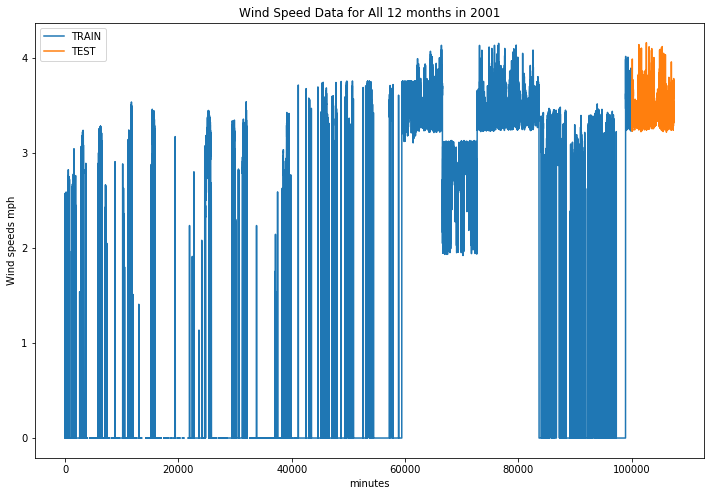

In [61]:
#Visualize the wind speed data for All 12 months in 2001
train = data.iloc[0:-7388,:]
test= data.iloc[-7388:, :]
train['avg_speed_imputed_transform'].plot(legend=True,label='TRAIN')
test['avg_speed_imputed_transform'].plot(legend=True,label='TEST',figsize=(12,8));
plt.title("Wind Speed Data for All 12 months in 2001");
plt.xlabel("minutes");
plt.ylabel("Wind speeds mph");

In [62]:
data = data[["coef","max_speed","max_dir","avg_speed","avg_dir","month","avg_speed_imputed_transform"]]

In [63]:
data = data.fillna(0)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data[['coef', 'max_speed', 'max_dir',"avg_dir","month"]],
                                                    data['avg_speed_imputed_transform'],
                                                    test_size = 0.2,shuffle = False)

In [65]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# The model will consider the last 12 months weighted average for forecasting
span = 12 
alpha = 2/(span+1)
model = ExponentialSmoothing(y_train.values,trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_level=alpha,smoothing_slope = 0.05)
test_predictions = model.predict(start=X_train.index.min(), end = X_test.index.max())

In [66]:
data['exp_smooth_preds']=pd.DataFrame(test_predictions)

In [67]:
mask1 = (data['exp_smooth_preds']>0)

In [68]:
data = data[mask1]

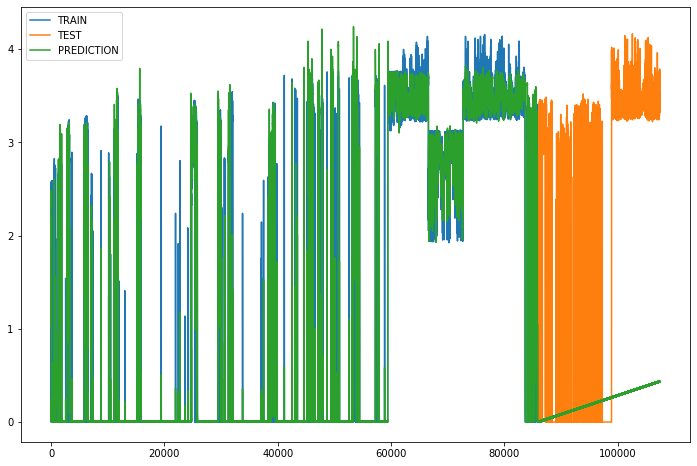

In [69]:
y_train.plot(legend=True,label='TRAIN')
y_test.plot(legend=True,label='TEST',figsize=(12,8))
data['exp_smooth_preds'].plot(legend=True,label='PREDICTION');

In [70]:
mse = mean_squared_error(data['avg_speed_imputed_transform'],data['exp_smooth_preds'])
print("Exponential Smoothing MSE is:", mse)
rmse = math.sqrt(mse)
print("Exponential Smoothing RMSE is:", rmse)
mean1 = statistics.mean(data['avg_speed_imputed_transform'])
print("Avg Wind Speed is:", mean1 )
mean2 = statistics.mean(data['exp_smooth_preds'])
print("Avg Wind Speed Prediction is:", mean2 )

Exponential Smoothing MSE is: 1.9224685602249103
Exponential Smoothing RMSE is: 1.3865311248669863
Avg Wind Speed is: 1.9851955660668104
Avg Wind Speed Prediction is: 1.4462484734080439


### References:
######1)Thurinav, Aars, "What is ARIMA?," Quora.com, Sept. 23, 2018, https://www.quora.com/What-is-ARIMA .
######2)Nelson, Joseph, "ARIMA Modeling," General Assembly, Data Science Immersive, June 15, 2019.
######3)Brown, Barbara G., "Time Series Models to Simulate and Forecast Wind Speed and Wind Power," Journal of Climate and Applied Meteorology, Vol 23, May, 22, 1984.
######4)Brownlee, Jason, "A Gentle Introduction to Exponential Smoothing for Time Series Forecasting in Python," Machine Learning Master, April 12, 2020, https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/.